In [40]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import json
import math
%matplotlib inline

In [41]:
with open("DNS_database.json", "r") as f:
    dns_data = json.load(f)

dns_record = []

for tld, domains in dns_data.items():
    for domain, records in domains.items():
        fqdn = f"{domain}.{tld}"
        for rec_type, rec_value in records.items():
            dns_record.append((fqdn, rec_type, rec_value))

In [42]:
query_IP = "23.185.0.3"

search_index = None
for i, (_, _, rec_value) in enumerate(dns_record):
    if rec_value == query_IP:
        search_index = i
        break

if search_index is None:
    raise ValueError("Query IP not found in DNS database!")

In [43]:
print(search_index, dns_record[search_index])

21 ('linux.com', 'A', '23.185.0.3')


In [44]:
n_entries = len(dns_record)
n_qubits = math.ceil(math.log2(n_entries))
print("Qubits required: " + str(n_qubits),"\nData entries: " + str(n_entries), "\nLog2 for qubits required: " + str(math.log2(n_entries)))

Qubits required: 5 
Data entries: 25 
Log2 for qubits required: 4.643856189774724


In [45]:
qc_FDNS = QuantumCircuit(n_qubits, n_qubits)
qc_FDNS.h(range(n_qubits))

In [46]:
oracle_FDNS = QuantumCircuit(n_qubits)
search_bin = format(search_index, f'0{n_qubits}b')
print(search_bin, search_index)
for idx, bit in enumerate(reversed(search_bin)):
    if bit == '0':
        oracle_FDNS.x(idx)
oracle_FDNS.h(n_qubits-1)
oracle_FDNS.mcx(list(range(n_qubits - 1)), n_qubits - 1)
oracle_FDNS.h(n_qubits - 1)
for idx, bit in enumerate(reversed(search_bin)):
    if bit == '0' :
        oracle_FDNS.x(idx)

oracle_gate_FDNS = oracle_FDNS.to_gate()
oracle_gate_FDNS.name = "Oracle"

10101 21


In [47]:
diffuser_FDNS = QuantumCircuit(n_qubits)
diffuser_FDNS.h(range(n_qubits))
diffuser_FDNS.x(range(n_qubits))
diffuser_FDNS.h(n_qubits - 1)
diffuser_FDNS.mcx(list(range(n_qubits - 1)), n_qubits - 1)
diffuser_FDNS.h(n_qubits - 1)
diffuser_FDNS.x(range(n_qubits))
diffuser_FDNS.h(range(n_qubits))

diffuser_gate_FDNS = diffuser_FDNS.to_gate()
diffuser_gate_FDNS.name = "Diffuser"

In [48]:
iterations = int((math.pi/4) * math.sqrt(n_entries))
for _ in range(iterations):
    qc_FDNS.append(oracle_gate_FDNS, range(n_qubits))
    qc_FDNS.append(diffuser_gate_FDNS, range(n_qubits))

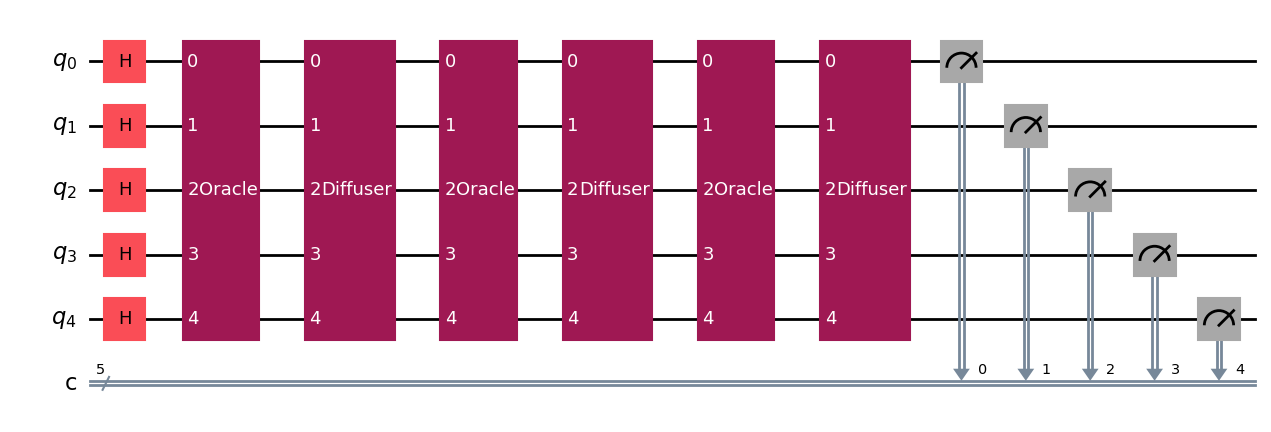

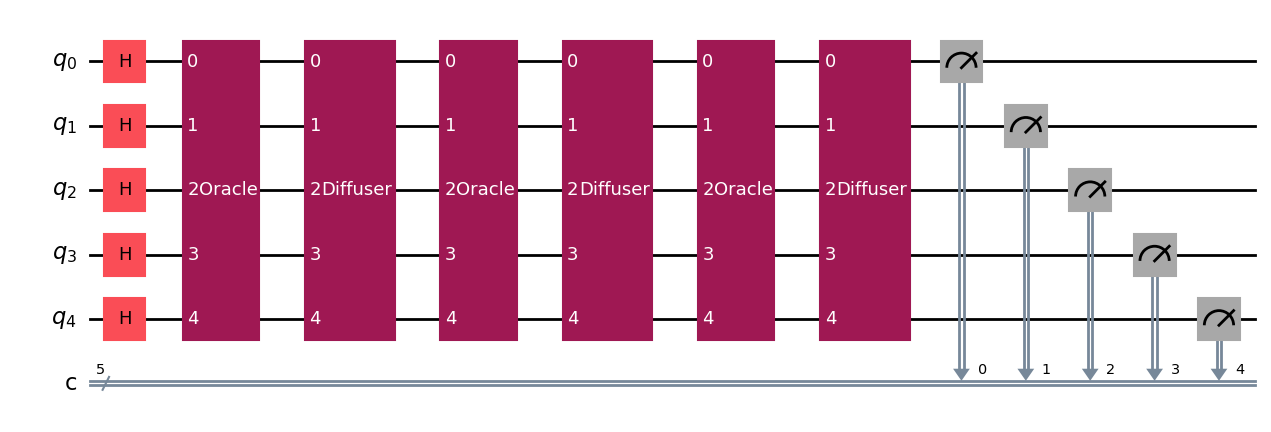

In [49]:
qc_FDNS.measure(range(n_qubits), range(n_qubits))
qc_FDNS.draw(output="mpl")

In [50]:
sim = AerSimulator()
compile_qc = transpile(qc_FDNS, sim)

In [51]:
result = sim.run(compile_qc, shots=2048).result()
counts = result.get_counts()

In [52]:
result = []

for outcome, count in counts.items():
    index = int(outcome, 2)
    if index < len(dns_record):
        domain, rec_type, rec_value = dns_record[index]
        result.append((count, outcome, index, domain, rec_type, rec_value))

result_sorted = sorted(result, key=lambda x: x[0], reverse=True)
for count, outcome, index, domain, rec_type, rec_value in result_sorted:
    print(f"Measured {outcome} (index: {index}) -> {domain} [{rec_type}] = {rec_value}, Counts: {count}")


Measured 10101 (index: 21) -> linux.com [A] = 23.185.0.3, Counts: 1846
Measured 00101 (index: 5) -> algomau.ca [A] = 141.193.213.20, Counts: 11
Measured 10011 (index: 19) -> ubuntu.com [A] = 185.125.190.29, Counts: 10
Measured 01001 (index: 9) -> en.wikipedia.com [A] = 208.80.154.224, Counts: 9
Measured 01011 (index: 11) -> en.wikipedia.com [CNAME] = dyna.wikimedia.org, Counts: 9
Measured 01100 (index: 12) -> x.com [A] = 172.66.0.227, Counts: 8
Measured 10001 (index: 17) -> whatsapp.com [A] = 31.13.80.53, Counts: 8
Measured 10110 (index: 22) -> linux.com [AAAA] = 2620:12a:8000::3, Counts: 8
Measured 10010 (index: 18) -> whatsapp.com [AAAA] = 2a03:2880:f20e:c5:face:b00c:0:167, Counts: 7
Measured 10000 (index: 16) -> facebook.com [AAAA] = 2a03:2880:f10e:83:face:b00c:0:25de, Counts: 7
Measured 10111 (index: 23) -> reddit.com [A] = 151.101.1.140, Counts: 7
Measured 10100 (index: 20) -> ubuntu.com [AAAA] = 2620:2d:4000:1::28, Counts: 7
Measured 00001 (index: 1) -> google.ca [AAAA] = 2607:f8

In [53]:
top_result = max(counts.items(), key=lambda x: x[1])
index = int(top_result[0], 2)
domain, rec_type, rec_value = dns_record[index]
print(f"Top result: {domain} [{rec_type}] = {rec_value}")

Top result: linux.com [A] = 23.185.0.3


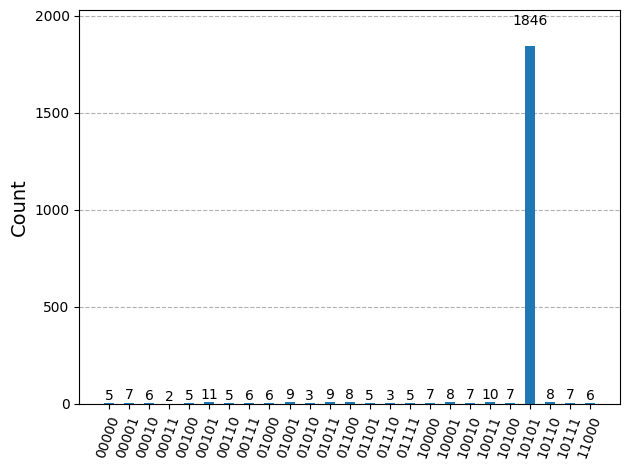

In [54]:
sorted_counts = {outcome: count for count, outcome, *_ in result_sorted}
plot_histogram(sorted_counts)
plt.show()

# Grover's Algorithm using QRAM implementation

In [55]:
def encode_data(val):
    if '.' in val:
        try:
            octets = val.split('.')
            return format(int(octets[-1]), '08b')
        except:
            pass
    return format(abs(hash(val)) % 256, '08b')

data_bin = [encode_data(value) for (_, _, value) in dns_record]
print(data_bin)

['00100100', '01000011', '00001110', '10001000', '01111011', '00010100', '11100000', '11001110', '10011110', '11100000', '11001110', '10011110', '11100011', '10101110', '11111000', '00100100', '11011101', '00110101', '01010011', '00011101', '10101100', '00000011', '01110101', '10001100', '01111000']


In [56]:
#QRAM Implementation
addr = QuantumRegister(n_qubits, 'addr')
data = QuantumRegister(8 , 'data')
c_addr = ClassicalRegister(n_qubits, 'c_addr')
qc_QRAM = QuantumCircuit(addr, data, c_addr)

qc_QRAM.h(addr)

In [57]:
search_octet = 29
search_bin = format(search_octet, '08b')

oracle_QRAM = QuantumCircuit(8)
for k, bit in enumerate(search_bin):
    if bit == '0':
        oracle_QRAM.x(k)
    
oracle_QRAM.h(7)
oracle_QRAM.mcx(list(range(7)),7)
oracle_QRAM.h(7)

for k, bit in enumerate(search_bin):
    if bit == '0':
        oracle_QRAM.x(k)
        
oracle_gate_QRAM = oracle_QRAM.to_gate()
oracle_gate_QRAM.name = "Oracle"

In [58]:
def diffuser(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)

    qc.mcx(list(range(n-1)), n-1)
    
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    return qc

diffuser_gate_QRAM = diffuser(n_qubits).to_gate()
diffuser_gate_QRAM.name = "Diffuser"

In [59]:
iterations = int((math.pi/4) * math.sqrt(n_entries))

for _ in range(iterations):
    for i, dval in enumerate(data_bin):
        bin_addr = format(i, f"0{n_qubits}b")[::-1]
        for j, bit in enumerate(bin_addr):
            if bit == '0':
                qc_QRAM.x(addr[j])
        for k, bit in enumerate(dval):
            if bit == '1':
                qc_QRAM.mcx(list(addr), data[k])
        for j, bit in enumerate(bin_addr):
            if bit == '0':
                qc_QRAM.x(addr[j])
    
    qc_QRAM.append(oracle_gate_QRAM, data)

    for i, dval in enumerate(data_bin[::-1]):
        bin_addr = format(len(data_bin)-1-i, f"0{n_qubits}b")[::-1]
        for j, bit in enumerate(bin_addr):
            if bit == '0':
                qc_QRAM.x(addr[j])
        for k, bit in enumerate(dval):
            if bit == '1':
                qc_QRAM.mcx(list(addr), data[k])
        for j, bit in enumerate(bin_addr):
            if bit == '0':
                qc_QRAM.x(addr[j])

    qc_QRAM.append(diffuser_gate_QRAM, addr)

qc_QRAM.measure(addr, c_addr)

In [60]:
sim = AerSimulator()
compile_qc = transpile(qc_QRAM, sim)

result = sim.run(compile_qc, shots=2048).result()
counts = result.get_counts()

In [61]:
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
for outcome, count in sorted_counts[:5]:
    idx = int(outcome.replace(' ', ''), 2)
    print(f"Outcome: {outcome} -> idx: {idx}, count: {count}")
    if idx < len(dns_record):
        print(f"Index {idx}: {dns_record[idx]} - Counts: {count}")

Outcome: 10011 -> idx: 19, count: 1831
Index 19: ('ubuntu.com', 'A', '185.125.190.29') - Counts: 1831
Outcome: 10010 -> idx: 18, count: 10
Index 18: ('whatsapp.com', 'AAAA', '2a03:2880:f20e:c5:face:b00c:0:167') - Counts: 10
Outcome: 00111 -> idx: 7, count: 10
Index 7: ('en.wikipedia.org', 'AAAA', '2620:0:861:ed1a::1') - Counts: 10
Outcome: 11010 -> idx: 26, count: 10
Outcome: 10100 -> idx: 20, count: 10
Index 20: ('ubuntu.com', 'AAAA', '2620:2d:4000:1::28') - Counts: 10


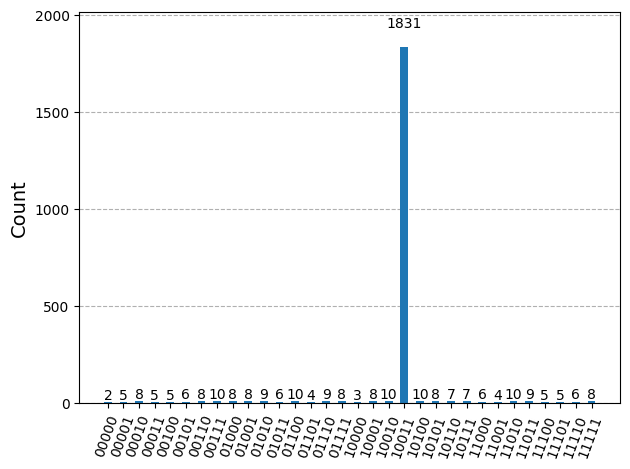

In [62]:
plot_histogram(counts)
plt.show()

# Classical DNS Query

In [64]:
def classical_dns_linear_search(records, query_val):
    for idx, (domain, rec_type, rec_value) in enumerate(records):
        if rec_value == query_val:
            return idx, (domain, rec_type, rec_value)
    return None, None

In [65]:
query_IP = "172.66.0.227"

idx, record = classical_dns_linear_search(dns_record, query_IP)

if record:
    print(f"Found at index {idx}: {record}")
else:
    print("Record not found or not existed!")

Found at index 12: ('x.com', 'A', '172.66.0.227')
